# Polygon point generation function

In [45]:
function regularPoly(n,r,center)
    a = 0; b = 0;
    points = zeros(n,2);
    points[1,1], points[1,2] = a, b+r;  
    theta = pi/2
    dTheta = 2*pi/n

    for i in 2:n
        theta += dTheta
        points[i,1],points[i,2] = a + r*cos(theta), b + r*sin(theta)
    end

    offsetX = -center;#minimum(points[:,1])
    offsety = -center;#minimum(points[:,2])

    for i in 1:n
            theta += dTheta
            points[i,1],points[i,2] = points[i,1] - offsetX,points[i,2] - offsety;
    end


    return points
    end

regularPoly (generic function with 1 method)

### Function to convert matrix generated like as it is done inthe function above to a vector

In [46]:
function matToVector(mat)
    len = length(mat)/2;
    len = convert(UInt32,len)
    items = [zeros(3) for _ in 1:len]
    for i in 1:len
        items[i][1],items[i][2] = mat[i,1],mat[i,2]; 
    end
    
    return items
    

end


matToVector (generic function with 1 method)

### Convert to tuple list for some other functions I made

In [47]:
function matToTupleList(mat)
    len = length(mat)/2;
    len = convert(UInt32,len)
    tuples = mat[1,1],mat[1,2];
    for i in 2:len
        tuples = cat(tuples,(mat[i,1], mat[i,2]),dims=1)
    end
    
    return tuples
    
end
    

matToTupleList (generic function with 1 method)

# Parameters and setup for testing

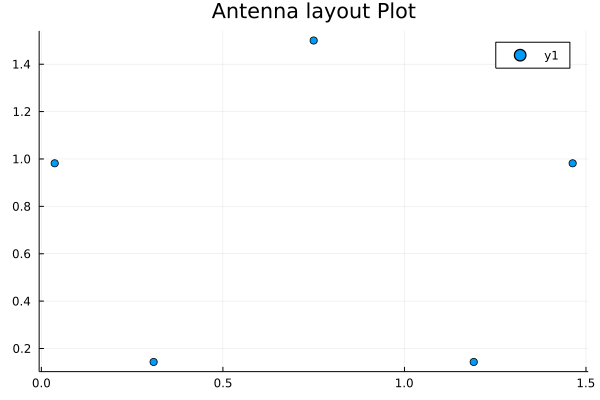

In [907]:
c = 3e8;
f = 100e6;
λ = c/f

r = λ/4;
numAntennas = 5;
antennaLayout = regularPoly(numAntennas,r,r)
AL = matToTupleList(antennaLayout)
ALv = matToVector(antennaLayout)
RadioSource = -200,-100;
RadioSourceV = [-200,-100]

using Plots
plot(antennaLayout[:,1], antennaLayout[:,2], seriestype = :scatter, title = "Antenna layout Plot")


In [908]:
@show(antennaLayout);
println()
@show(AL)
println()
@show(ALv)


antennaLayout = [0.75 1.5; 0.03670761277863488 0.9817627457812106; 0.3091610607806451 0.14323725421878952; 1.1908389392193546 0.1432372542187893; 1.4632923872213652 0.9817627457812104]

AL = [(0.75, 1.5), (0.03670761277863488, 0.9817627457812106), (0.3091610607806451, 0.14323725421878952), (1.1908389392193546, 0.1432372542187893), (1.4632923872213652, 0.9817627457812104)]

ALv = [[0.75, 1.5, 0.0], [0.03670761277863488, 0.9817627457812106, 0.0], [0.3091610607806451, 0.14323725421878952, 0.0], [1.1908389392193546, 0.1432372542187893, 0.0], [1.4632923872213652, 0.9817627457812104, 0.0]]


5-element Vector{Vector{Float64}}:
 [0.75, 1.5, 0.0]
 [0.03670761277863488, 0.9817627457812106, 0.0]
 [0.3091610607806451, 0.14323725421878952, 0.0]
 [1.1908389392193546, 0.1432372542187893, 0.0]
 [1.4632923872213652, 0.9817627457812104, 0.0]

# Analytical angle of arrival using vectors

In [909]:
function AngleV(Rx,Tx)
    
    ref = [1,0,0];
    dif = Tx-Rx;
    θ= acos(clamp(ref⋅dif/(norm(ref)*norm(dif)), -1, 1))
    
    offset = 0;
    if Tx[2]<=Rx[2]
        offset = 2*pi;
       # println("offset 3/4")
    else 
       # println("offset 1/2")
    end
    return abs(offset-θ) 
end

AngleV (generic function with 1 method)

# Determine angle between two antenna simulation

### Function for distance between two points

In [910]:
function distance(a,b)
   return sqrt((a[1]-b[1])^2+(a[2]-b[2])^2);
end

distance (generic function with 1 method)

In [911]:
function distanceV(a,b)
   return norm(a-b)
end

distanceV (generic function with 1 method)

### Function for time delay between two points

In [912]:
function tV(a,b)
   return distanceV(a,b)/c; 
end

tV (generic function with 1 method)

In [913]:
function ΔtV(Rx1,Rx2,src)
    
    return tV(Rx1,src)-tV(Rx2,src)
end

ΔtV (generic function with 1 method)

### Function for time delay based on frequency/wavelength

In [914]:
function Δtλ(Rx1,Rx2,src,freq,c)
    λ=c/freq;
    # distanceV must be less than lambda
    phase1 = (distanceV(Rx1,src)%λ)/λ;#phase as a fraction of a full wavelength 
    phase2 = (distanceV(Rx2,src)%λ)/λ;#phase as a fraction of a full wavelength
    Δphase = angle(ℯ^(im*2pi*phase1)*conj(ℯ^(im*2pi*phase2)))
    return   λ*Δphase/(2π*c) 
end

Δtλ (generic function with 1 method)

In [915]:
angle(ℯ^(im*2pi*1)*conj(ℯ^(im*2pi*999.51)))*180/pi

176.40000000001157

### Show that both Δt functions produce the same result

In [916]:
@show ΔtV([1,1,2],[1,2,3],[1000,4000,2000])

@show Δtλ([1,1,2],[1,2,3],[1000,4000,2000],100e6,3e8)

ΔtV([1, 1, 2], [1, 2, 3], [1000, 4000, 2000]) = 4.36394163158744e-9
Δtλ([1, 1, 2], [1, 2, 3], [1000, 4000, 2000], 1.0e8, 3.0e8) = 4.363941631587901e-9


4.363941631587901e-9

# Function to generate readings from Antenna array

In [917]:
function measureAntennaArray(AntennaLayout,src,freq)
    numAntennas = length(AntennaLayout)
    row = zeros(convert(UInt32,((numAntennas-1)*(numAntennas)//2)));
    index = 1;
    for n in 1:numAntennas-1
        for i in n+1:numAntennas
            row[index] = Δtλ(AntennaLayout[n],AntennaLayout[i],src,freq,3e8) ;
            index+=1;
        end
    end
    return row
end


measureAntennaArray (generic function with 1 method)

In [918]:
using LinearAlgebra
measureAntennaArray(ALv,[200,200,0],100e6)



10-element Vector{Float64}:
 -2.9037146679176357e-9
 -4.235402354444583e-9
 -2.160430725151627e-9
  4.6072865528590973e-10
 -1.3316876865269478e-9
  7.432839427660084e-10
  3.364443323203545e-9
  2.0749716292929566e-9
  4.6961310097304935e-9
  2.621159380437537e-9

# Generate LUTs

In [919]:
function generateLUT(Rx,src,r,freq)
    
    numAntennas = length(Rx)
    LUT = [zeros(numAntennas-1) for _ in 1:length(src)]
    
    #row = zeros(numAntennas-1);
    for i in 1:length(src) 
    
        LUT[i]=measureAntennaArray(Rx,src[i],freq);
    end
    
    TrueValues = zeros(360);
    for i in  1:360
        TrueValues[i] = (AngleV([r,r,0],src[i])*180/pi)
    end
    
    return LUT, TrueValues
    
    
    
    
end

generateLUT (generic function with 1 method)

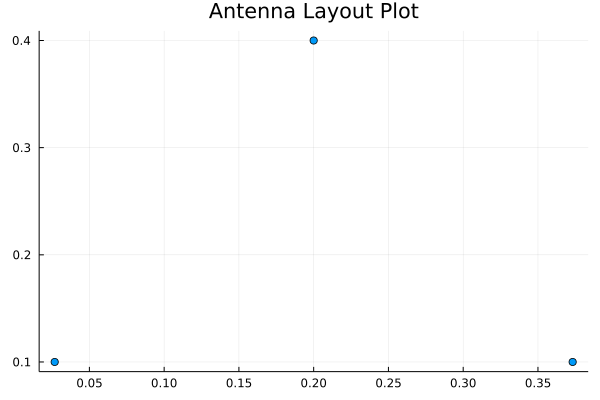

In [1052]:
c = 3e8;
f = 100e6;
λ = c/f
r = 0.2;
numAntennas = 3

RadioSources = regularPoly(360,1000,r)
RadioSourcesV = matToVector(RadioSources)


AntennaLayout = regularPoly(numAntennas,r,r)
ALv = matToVector(AntennaLayout)



l,t = generateLUT(ALv,RadioSourcesV,r,f);

rxplot=plot(AntennaLayout[:,1], AntennaLayout[:,2], seriestype = :scatter, title = "Antenna Layout Plot",legend=false)


# MSE function

In [1053]:
function MSE(x,y)
    n = minimum([length(x),length(y)]);
    total=0;
    for i in 1:n
        total+=(x[i]-y[i])^2;
    end
    
    return total/n
    
    
end

MSE (generic function with 1 method)

In [1054]:
function MSE2(x,y)
   return sum((x.-y).^2)/length(x)
end

MSE2 (generic function with 1 method)

In [1055]:
@show MSE([1,2,3,4],[4,5,6,7])
@show MSE2([1,2,3,4],[4,5,6,7])

MSE([1, 2, 3, 4], [4, 5, 6, 7]) = 9.0
MSE2([1, 2, 3, 4], [4, 5, 6, 7]) = 9.0


9.0



# Correlate direction against LUT

In [1056]:
function LookUpAngle(LUT,Truth,measurement)
    
    maxcor = 2^32;
    maxcorindex = 1;
    LOSS = zeros(length(LUT))
       for i in 1:length(LUT)
        value = MSE(LUT[i],measurement);
        LOSS[i]= value;
        if value<maxcor
            maxcor = value;
            maxcorindex = i;
            
        end
        
    end
    
    return Truth[maxcorindex],LOSS
    
end

LookUpAngle (generic function with 1 method)

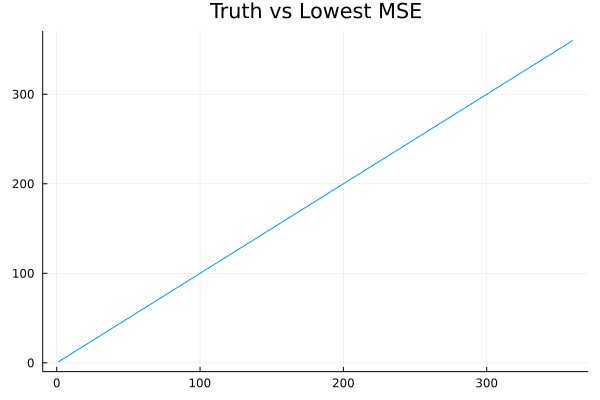

In [1057]:
using Statistics
smallcircle= regularPoly(360,1000,r);
smallcircleV = matToVector(smallcircle);
plotter = zeros(360)
loss = zeros(360);
for i in 1:360
    plotter[i],loss=LookUpAngle(l,t,measureAntennaArray(ALv,smallcircleV[i],f))
end
#plotter[1:90],plotter[91:360]=plotter[271:360],plotter[1:270]
#plotter[1:359],plotter[360]=plotter[2:360],plotter[1]

plot(circshift(plotter,89), title = "Truth vs Lowest MSE", legend = false)

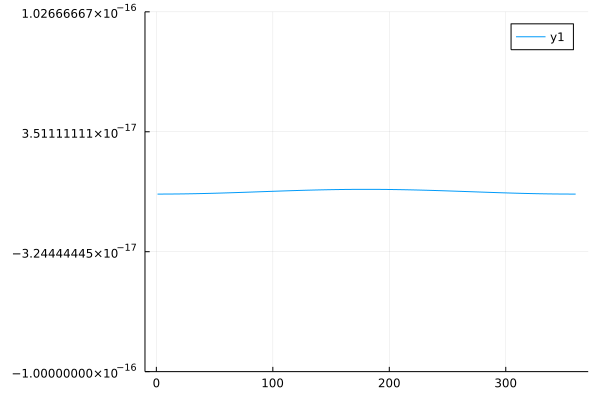

In [1058]:
plot(loss)

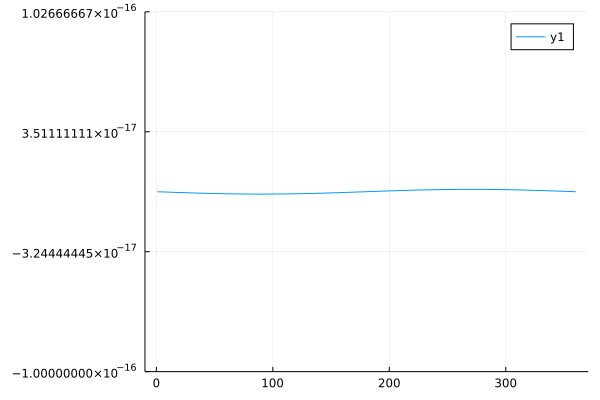

In [1059]:
psefgsd,loss2=LookUpAngle(l,t,measureAntennaArray(ALv,smallcircleV[90],f))
plot(loss2)

In [1060]:
for i in 1:length(l)
    println(l[i],"  truth = " ,t[i])
end

[-1.0000499949997752e-9, -1.0000499949997752e-9, 0.0]  truth = 90.0
[-9.898225156560633e-10, -1.009972803741069e-9, -2.0150288085005633e-11]  truth = 91.0
[-9.792934802055697e-10, -1.0195879202437174e-9, -4.029444003814748e-11]  truth = 92.0
[-9.684660950589814e-10, -1.0288924166536621e-9, -6.042632159468049e-11]  truth = 93.00000000000001
[-9.573436575639486e-10, -1.0378834597865231e-9, -8.053980222257439e-11]  truth = 94.0
[-9.459295550042654e-10, -1.046558311992385e-9, -1.0062875698811959e-10]  truth = 95.0
[-9.342272635653143e-10, -1.0549143319864623e-9, -1.2068706842114796e-10]  truth = 96.0
[-9.222403472794364e-10, -1.0629489756509732e-9, -1.4070862837153676e-10]  truth = 97.00000000000001
[-9.099724569383247e-10, -1.0706597968116206e-9, -1.6068733987329592e-10]  truth = 98.00000000000001
[-8.974273289845766e-10, -1.0780444479807248e-9, -1.806171189961484e-10]  truth = 99.00000000000001
[-8.846087843706604e-10, -1.085100681067388e-9, -2.0049189669672746e-10]  truth = 100.00000000

[7.875614639870796e-10, -3.375694781455728e-10, -1.1251309421326526e-9]  truth = 192.99999999999912
[8.021800902038951e-10, -3.1824800666565086e-10, -1.1204280968695462e-9]  truth = 193.9999999999991
[8.165543118714899e-10, -2.988296217157923e-10, -1.1153839335872822e-9]  truth = 194.99999999999912
[8.306797504315002e-10, -2.7932023674528273e-10, -1.109999987176783e-9]  truth = 195.9999999999991
[8.445521031698416e-10, -2.5972579289145864e-10, -1.1042778960613e-9]  truth = 196.9999999999991
[8.581671445297915e-10, -2.4005225717170803e-10, -1.0982194017014993e-9]  truth = 197.99999999999906
[8.71520727399305e-10, -2.2030562066599174e-10, -1.091826348065297e-9]  truth = 198.99999999999906
[8.84608784371039e-10, -2.0049189669634936e-10, -1.0851006810673883e-9]  truth = 199.99999999999903
[8.974273289845766e-10, -1.806171189961484e-10, -1.0780444479807248e-9]  truth = 200.99999999999906
[9.099724569383247e-10, -1.6068733987329592e-10, -1.0706597968116206e-9]  truth = 201.99999999999903
[9.

[6.118461647508866e-10, 1.1539930928483958e-9, 5.421469280975088e-10]  truth = 297.99999999999795
[5.946637624087238e-10, 1.154522651197946e-9, 5.598588887892222e-10]  truth = 298.99999999999795
[5.773002663041401e-10, 1.1547005326057538e-9, 5.774002663016135e-10]  truth = 299.99999999999795
[5.597609646323081e-10, 1.1545266810450503e-9, 5.947657164127423e-10]  truth = 300.99999999999795
[5.420511990867753e-10, 1.154001147632092e-9, 6.119499485453165e-10]  truth = 301.9999999999979
[5.241763632303297e-10, 1.153124090610618e-9, 6.289477273802884e-10]  truth = 302.9999999999979
[5.061419008552548e-10, 1.151895775306002e-9, 6.457538744507472e-10]  truth = 303.9999999999979
[4.879533043254017e-10, 1.1503165740475654e-9, 6.623632697221634e-10]  truth = 304.9999999999979
[4.696161129042296e-10, 1.1483869660567816e-9, 6.787708531525523e-10]  truth = 305.9999999999979
[4.511359110707273e-10, 1.1461075373032753e-9, 6.949716262325482e-10]  truth = 306.99999999999784
[4.325183268160047e-10, 1.143

[-1.1371382903750297e-9, -3.9496795301867395e-10, 7.421703373563558e-10]  truth = 49.99999999999668
[-1.140466411828811e-9, -4.1384629448089103e-10, 7.266201173479198e-10]  truth = 50.99999999999666
[-1.1434471524679183e-9, -4.325985390532121e-10, 7.108486134147061e-10]  truth = 51.999999999996646
[-1.1460796025687615e-9, -4.5121897327362593e-10, 6.948606292951353e-10]  truth = 52.99999999999664
[-1.1483629584828731e-9, -4.697019238752402e-10, 6.786610346076327e-10]  truth = 53.999999999996625
[-1.1502965228832332e-9, -4.880417595162123e-10, 6.622547633670209e-10]  truth = 54.99999999999662
[-1.151879704980274e-9, -5.06232892497186e-10, 6.456468124830882e-10]  truth = 55.99999999999661
[-1.1531120207030194e-9, -5.242697804639342e-10, 6.288422402390854e-10]  truth = 56.9999999999966
[-1.1539930928480161e-9, -5.421469280975092e-10, 6.118461647505071e-10]  truth = 57.99999999999658
[-1.1545226511983242e-9, -5.598588887892218e-10, 5.946637624091026e-10]  truth = 58.99999999999657
[-1.15470

In [1061]:
for i in plotter
    println(i)
end

90.0
91.0
92.0
93.00000000000001
94.0
95.0
96.0
97.00000000000001
98.00000000000001
99.00000000000001
100.00000000000003
101.00000000000001
102.00000000000001
103.00000000000001
104.00000000000003
105.00000000000003
106.00000000000001
107.00000000000001
108.00000000000003
109.00000000000003
110.00000000000003
111.00000000000003
112.00000000000004
113.00000000000003
114.00000000000003
115.00000000000003
116.0
117.0
118.0
118.99999999999997
119.99999999999997
120.99999999999996
121.99999999999994
122.99999999999993
123.99999999999993
124.9999999999999
125.9999999999999
126.9999999999999
127.99999999999987
128.99999999999986
129.99999999999986
130.99999999999986
131.99999999999983
132.99999999999983
133.9999999999998
134.9999999999998
135.9999999999998
136.99999999999977
137.99999999999977
138.99999999999974
139.99999999999974
140.99999999999972
141.99999999999972
142.99999999999972
143.9999999999997
144.9999999999997
145.99999999999966
146.99999999999966
147.99999999999963
148.9999999999

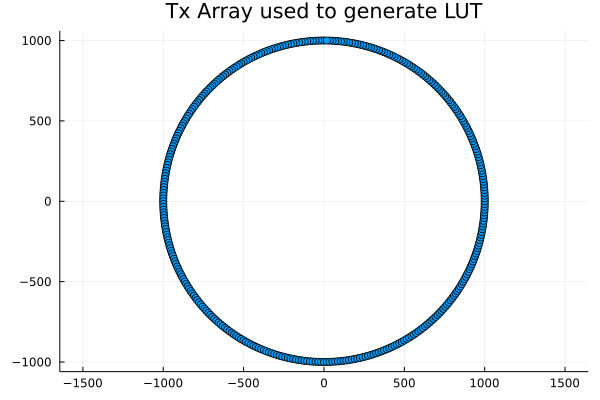

In [1062]:
Txplot=plot(smallcircle[:,1], smallcircle[:,2], seriestype = :scatter, title = "Tx Array used to generate LUT",aspectratio=:equal,legend=false)


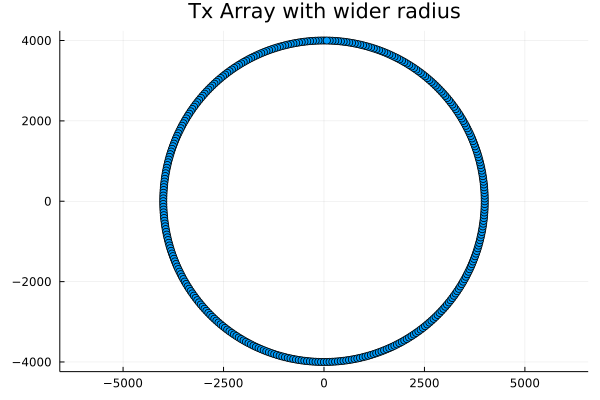

In [1063]:
mediumcircle= regularPoly(360,4000,r);
mediumcircleV = matToVector(mediumcircle);
Txplot2=plot(mediumcircle[:,1], mediumcircle[:,2], seriestype = :scatter, title = "Tx Array with wider radius",aspectratio=:equal,legend=false)


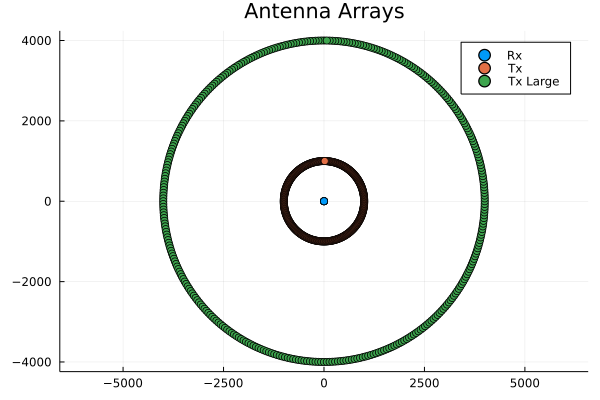

In [1064]:
plot(antennaLayout[:,1], antennaLayout[:,2], seriestype = :scatter, title = "Antenna layout Plot", label ="Rx")
plot!(smallcircle[:,1], smallcircle[:,2], seriestype = :scatter, title = "Tx Array used to generate LUT",aspectratio=:equal,legend=false, label = "Tx")

plot!(mediumcircle[:,1], mediumcircle[:,2], seriestype = :scatter, title = "Antenna Arrays",aspectratio=:equal,legend=true,label="Tx Large")


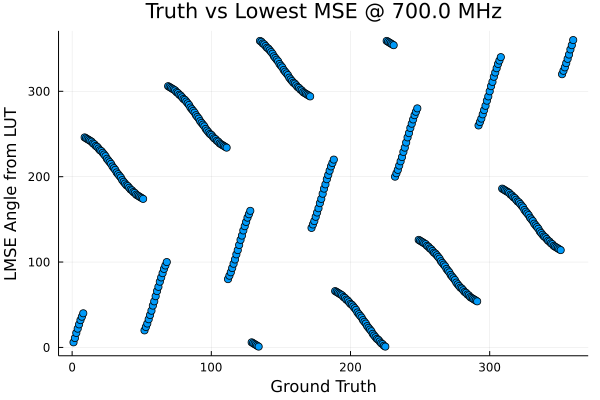

In [1142]:
ftest = 700e6
plotter = zeros(360)
loss = [zeros(360) for _ in 1:360]
for i in 1:360
    plotter[i],loss[i]=LookUpAngle(l,t,measureAntennaArray(ALv,mediumcircleV[i],ftest))
end
#plotter[1:90],plotter[91:360]=plotter[271:360],plotter[1:270]
#plotter[1:359],plotter[360]=plotter[2:360],plotter[1]

plot(circshift(plotter,89), title = "Truth vs Lowest MSE @ "*string(ftest/1e6)*" MHz", legend = false,seriestype=:scatter,xlabel="Ground Truth",ylabel="LMSE Angle from LUT")

In [1143]:
@show LookUpAngle(l,t,measureAntennaArray(ALv,smallcircleV[1],100e6));
println()
@show smallcircleV[1];
println();
@show testPOs = [0,500,179];
println();
@show LookUpAngle(l,t,measureAntennaArray(ALv,testPOs,100e6));

LookUpAngle(l, t, measureAntennaArray(ALv, smallcircleV[1], 1.0e8)) = (90.0, [0.0, 2.0303252565035583e-22, 8.120684424092695e-22, 1.8269227879314754e-21, 3.247287352334725e-21, 5.072730769255558e-21, 7.302698643524262e-21, 9.936513714507416e-21, 1.2973376056892089e-20, 1.6412363316777796e-20, 2.02524309843795e-20, 2.4492412702992215e-20, 2.913102061439248e-20, 3.4166845738885405e-20, 3.9598358393540747e-20, 4.542390864387526e-20, 5.164172679358358e-20, 5.824992390780532e-20, 6.524649237377414e-20, 7.262930649530883e-20, 8.039612312413951e-20, 8.854458232462346e-20, 9.707220807540224e-20, 1.05976409003484e-19, 1.1525447915611053e-19, 1.2490359880333454e-19, 1.3492083527787236e-19, 1.4530314384959237e-19, 1.56047368628728e-19, 1.6715024350920814e-19, 1.7860839314175963e-19, 1.904183339408906e-19, 2.0257647512458351e-19, 2.1507911978827283e-19, 2.279224660087957e-19, 2.411026079821117e-19, 2.5461553719224316e-19, 2.6845714361327354e-19, 2.8262321693980927e-19, 2.971094478503957e-19, 3.119

LookUpAngle(l, t, measureAntennaArray(ALv, testPOs, 1.0e8)) = (90.0, [2.283418753271391e-21, 2.4658003948542632e-21, 3.030417913849653e-21, 3.977099883943776e-21, 5.305558871214673e-21, 7.015391519069143e-21, 9.106078667151599e-21, 1.1576985504017687e-20, 1.4427361754969028e-20, 1.7656341903086876e-20, 2.1262945444319343e-20, 2.5246077177205105e-20, 2.960452752634572e-20, 3.4336972898664685e-20, 3.9441976075474413e-20, 4.4917986636014845e-20, 5.076334141679322e-20, 5.697626500232245e-20, 6.355487025102495e-20, 7.049715885316554e-20, 7.78010219229905e-20, 8.546424062269468e-20, 9.348448682093768e-20, 1.0185932378173728e-19, 1.1058620688909416e-19, 1.1966248440051748e-19, 1.2908539823532976e-19, 1.3885208479601583e-19, 1.4895957581614853e-19, 1.5940479924639168e-19, 1.7018458016846647e-19, 1.8129564174069804e-19, 1.9273460617497745e-19, 2.0449799574550114e-19, 2.165822338256446e-19, 2.289836459574268e-19, 2.4169846094935265e-19, 2.5472281200619423e-19, 2.680527378853393e-19, 2.8168418408

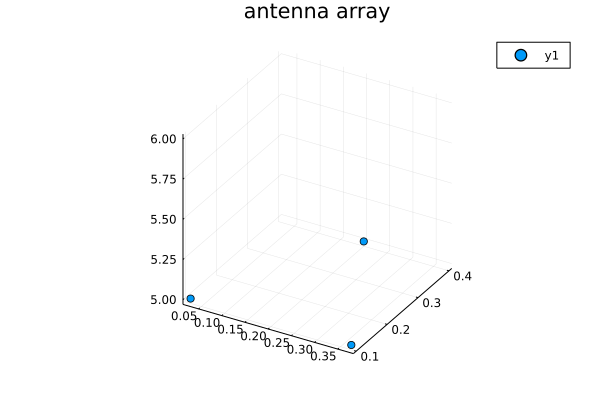

In [1144]:
x = [smallcircleV[i][1] for i in 1:360],[smallcircleV[i][2] for i in 1:360],[smallcircleV[i][3] for i in 1:360]
y = [ALv[i][1] for i in 1:numAntennas],[ALv[i][2] for i in 1:numAntennas],[5 for i in 1:numAntennas]
plot(y,title="antenna array" ,seriestype = :scatter)

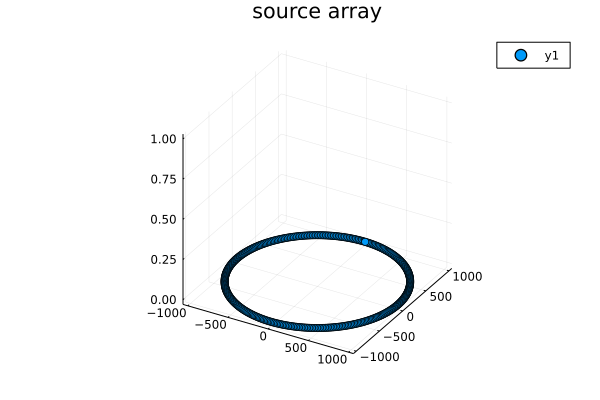

In [1145]:
plot(x,title="source array" ,seriestype = :scatter)

In [1146]:
plot([1,2,3])
ALv

3-element Vector{Vector{Float64}}:
 [0.2, 0.4, 0.0]
 [0.026794919243112225, 0.10000000000000006, 0.0]
 [0.3732050807568877, 0.09999999999999992, 0.0]

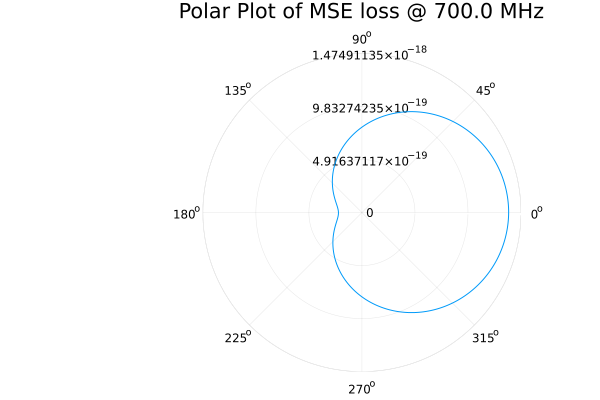

In [1151]:
using Plots

ts = range(0, 2pi, length=360)
plot(ts,loss[1], proj=:polar, legend=false,title="Polar Plot of MSE loss @ 700.0 MHz")

In [1148]:
l1=zeros(360)
l2 = zeros(360)
l3=zeros(360)
l4 = zeros(360)
l5 = zeros(360)
for I= 1:360
    l1[I]=l[I][1]
    l2[I]=l[I][2]
    l3[I]=l[I][3]
    #l4[I]=l[I][4]
    #l5[I]=l[I][5]

end

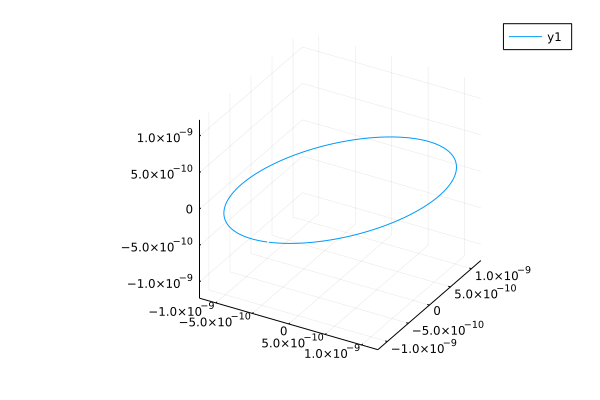

In [1149]:
plot1=plot(l2,l3,l1)



In [1150]:
ld,td = generateLUT(ALv,mediumcircleV,r,2000e6);


In [1118]:
l1=zeros(360)
l2 = zeros(360)
l3=zeros(360)
l4 = zeros(360)
l5 = zeros(360)
for I= 1:360
    l1[I]=l[I][1]
    l2[I]=l[I][2]
    l3[I]=l[I][3]
    #l4[I]=l[I][4]
    #l5[I]=l[I][5]

end

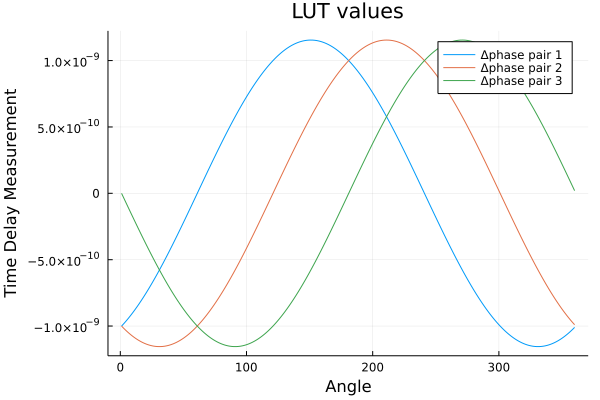

In [1096]:
plot(l1,title="LUT values",xlabel="Angle",ylabel="Time Delay Measurement",label="Δphase pair 1")
plot!(l2,title="LUT values",xlabel="Angle",ylabel="Time Delay Measurement",label="Δphase pair 2")
plot!(l3,title="LUT values",xlabel="Angle",ylabel="Time Delay Measurement",label="Δphase pair 3")

In [1084]:
lp=zeros(360)
lp2=zeros(360)
lp3=zeros(360)
for i=1:360
    lp[i]=ld[i][1]
     lp2[i]=ld[i][2]
     lp3[i]=ld[i][3]
end
    

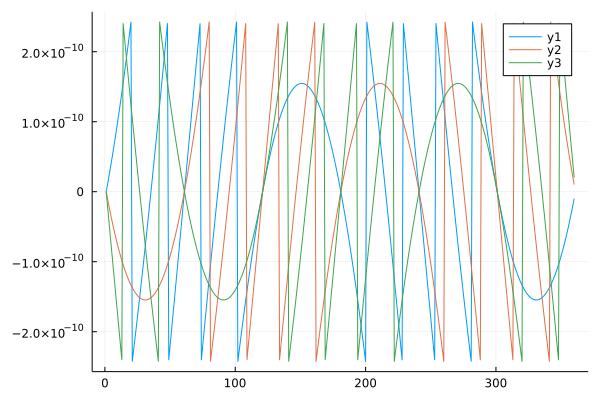

In [1085]:
plot(lp)
plot!(lp2)
plot!(lp3)